In [103]:
from MyModels import *
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
plt.rcParams['figure.figsize'] = [20, 5]
%matplotlib inline  

In [49]:
f_data_path = "PrepedData/"
f_modele_path = 'Model/'

f_HHData = f_data_path + 'HHDataId/'
mode_path = "Models/"

outpath=r"E:\Programing\Magister\Load Prediction\Results\Plots\NARX\\"

predLen = 100

In [3]:
data = pd.read_feather(f_data_path + "LPG-Profile-4.feather")

In [4]:
x = data['energy']
x = np.sum(x.values.reshape(-1,180),axis=1)

In [20]:
split = 0.8
l = int(1000 * split)
e = int(1000 * (1-split))
x_train = x[0:l].reshape(-1,1)
y_train = x[1:l+1].reshape(-1,1)
x_valid = x[l+2:l+e - 1].reshape(-1,1)
y_valid = x[l+3:l+e].reshape(-1,1)

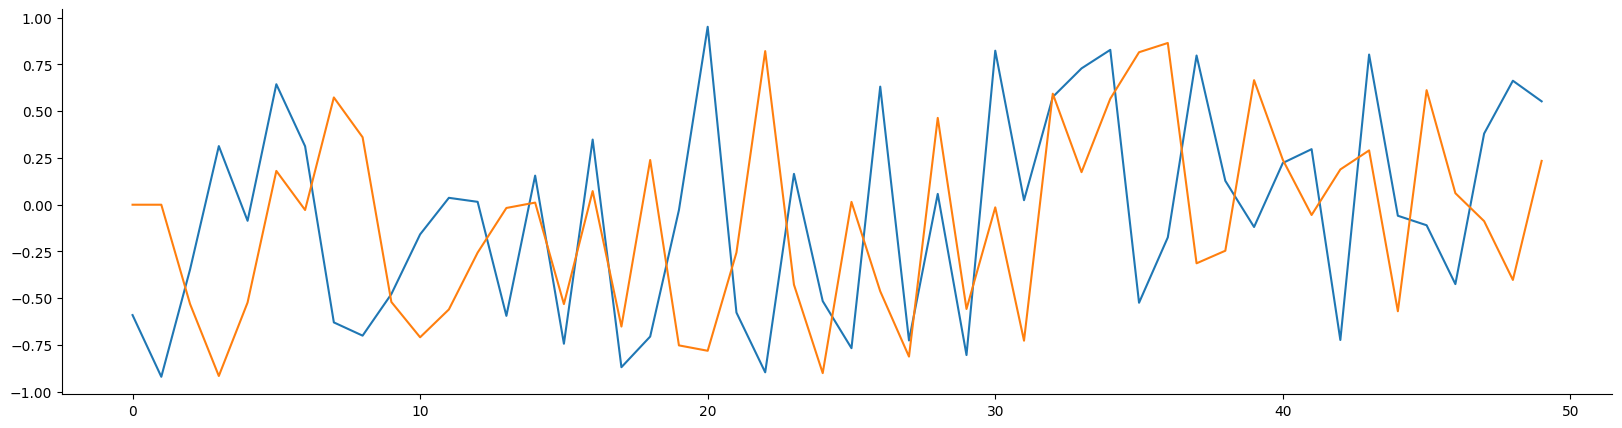

In [10]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(x_train[0:50])
plt.plot(y_train[0:50])

### Ploting functions

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False


def plot_results(
    y=None,
    *,
    yhat=None,
    figsize=(10, 6),
    n=100,
    style="seaborn-v0_8-white",
    facecolor="white",
    title="Free run simulation",
    outpath=r"E:\Programing\Magister\Load Prediction\Results\Plots\NARX\test.png",
    showInfo = True
):
    plt.style.use(style)
    plt.rcParams["axes.facecolor"] = facecolor
    fig, ax = plt.subplots(figsize=figsize, facecolor=facecolor)
    ax.plot(y[:n], c="#1f77b4", alpha=1, marker="o", label="Data", linewidth=1.5)
    ax.plot(yhat[:n], c="#ff7f0e", marker="*", label="Model", linewidth=1.5)

    ax.set_title(title, fontsize=18)
    ax.legend()
    ax.tick_params(labelsize=14)
    ax.set_xlabel("Samples", fontsize=14)
    ax.set_ylabel("y, $\hat{y}$", fontsize=14)
    plt.savefig(outpath)
    if showInfo: plt.show()
    else: plt.close()


def plot_residues_correlation(
    data=None,
    *,
    figsize=(10, 6),
    n=100,
    style="seaborn-v0_8-white",
    facecolor="white",
    title="Residual Analysis",
    ylabel="Correlation",
    outpath=r"E:\Programing\Magister\Load Prediction\Results\Plots\NARX\test.png",
    showInfo = True
):
    plt.style.use(style)
    plt.rcParams["axes.facecolor"] = facecolor
    fig, ax = plt.subplots(figsize=figsize, facecolor=facecolor)
    ax.plot(data[0], color="#1f77b4")
    ax.axhspan(data[1], data[2], color="#ccd9ff", alpha=0.5, lw=0)
    ax.set_xlabel("Lag", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(labelsize=14)
    ax.set_ylim([-1, 1])
    ax.set_title(title, fontsize=18)
    plt.savefig(outpath)
    if showInfo: plt.show()
    else: plt.close()

### Test func Def

In [18]:
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
x_train, x_valid, y_train, y_valid = get_siso_data(
  n=1000,
  colored_noise=False,
  sigma=0.001,
  train_percentage=80
)

In [69]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial
from sysidentpy.utils.display_results import results
#from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation
from sysidentpy.residues.residues_correlation import compute_cross_correlation
from matplotlib import pyplot as plt

def TestFROLS(deg, showInfo=True):
  basis_function=Polynomial(degree=2)
  model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
  )
  model.fit(X=x_train, y=y_train)
  yhat = model.predict(X=x_valid, y=y_valid)
  rrse = root_relative_squared_error(y_valid, yhat)
  if showInfo: print(rrse)
  r = pd.DataFrame(
    results(
      model.final_model, model.theta, model.err,
      model.n_terms, err_precision=8, dtype='sci'
      ),
    columns=['Regressors', 'Parameters', 'ERR'])
  if showInfo: print(r)
  r.to_csv(outpath+f"FROLS\\results-{deg}.csv")

  plot_results(y=y_valid, yhat=yhat, n=predLen, title=f"Przwidywania dla FROLS stopnia {deg}",outpath=outpath+f"FROLS\\results-{deg}.png",showInfo=showInfo)
  ee = compute_residues_autocorrelation(y_valid[:predLen], yhat[:predLen])
  plot_residues_correlation(data=ee, ylabel="$e^2$", title=f"Pozostalości $e^2$ dla FROLS stopnia {deg}",outpath=outpath+f"FROLS\\residuesEE-{deg}.png",showInfo=showInfo)
  x1e = compute_cross_correlation(y_valid, yhat, x_valid)
  plot_residues_correlation(data=x1e, ylabel="$x_1e$", title=f"Pozostalości $x_1e$ dla FROLS stopnia {deg}",outpath=outpath+f"FROLS\\residuesX1E-{deg}.png",showInfo=showInfo)


In [139]:
from torch import nn
from sysidentpy.neural_network import NARXNN
from sysidentpy.basis_function import Polynomial
#from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation
from sysidentpy.residues.residues_correlation import compute_cross_correlation
import logging
import sys

def TestNARXNN (deg, linModel, ylag, xlag, title, showInfo=True):

  if showInfo:
    logging.getLogger().setLevel(logging.INFO)
  else:
    logging.getLogger().setLevel(logging.WARNING)
    
  basis_function=Polynomial(degree=deg)

  narx_net = NARXNN(
    net=linModel(),
    ylag=xlag,
    xlag=ylag,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func='mse_loss',
    optimizer='Adam',
    epochs=200,
    verbose=True,
    optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
  )

  tName = title.replace(' ', '-')
  d = predLen
  output = narx_net.fit(X=x_train, y=y_train,X_test=x_valid, y_test=y_valid)
  yhat = narx_net.predict(X=x_valid[:d], y=y_valid[:d])
  plot_results(y=y_valid[:d], yhat=yhat, n=1000, title="Przwidywania dla NARXNN "+title,outpath=outpath+f"NARXNN\\result-{tName}.png",showInfo=showInfo)
  ee = compute_residues_autocorrelation(y_valid[:d], yhat)
  plot_residues_correlation(data=ee, ylabel="$e^2$", title=f"Pozostalości $e^2$ dla NARXNN "+title,outpath=outpath+f"NARXNN\\residuesEE-{tName}.png",showInfo=showInfo)
  x1e = compute_cross_correlation(y_valid[:d], yhat, x_valid[:d])
  plot_residues_correlation(data=x1e, ylabel="$x_1e$", title=f"Pozostalości $x_1e$ dla NARXNN "+title,outpath=outpath+f"NARXNN\\residuesX1E-{tName}.png",showInfo=showInfo)

  plt.plot(output.train_loss)
  plt.plot(output.val_loss)
  plt.xlabel("Epoki")
  plt.ylabel("Strata w MSE")
  plt.legend(['Straty dla danych trenujacych','Straty dla danych walidujących'])
  plt.savefig(outpath+f"NARXNN\\train-{tName}.png")
  plt.close()

  with open(outpath+f"NARXNN\\results-{tName}.txt", 'w') as f:
    f.write("MSE: " + str(mean_squared_error(y_valid[:predLen], yhat[:predLen] )) + "\n")
    f.write("R2:  " + str(r2_score(y_valid[:predLen], yhat[:predLen] ))+ "\n")
    f.write("MAE: " + str(mean_absolute_error(y_valid[:predLen], yhat[:predLen] ))+ "\n")

In [137]:
from sysidentpy.general_estimators import NARX
from catboost import CatBoostRegressor
from sysidentpy.basis_function._basis_function import Polynomial
#from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

def TestCatBoost(deg, xlag, ylag, showInfo=True):
    basis_function=Polynomial(degree=deg)

    catboost_narx = NARX(
        base_estimator=CatBoostRegressor(
            iterations=300,
            learning_rate=0.1,
            depth=6),
        xlag=xlag,
        ylag=ylag,
        basis_function=basis_function,
        model_type="NARMAX",
        fit_params={'verbose': False}
    )

    output = catboost_narx.fit(X=x_train, y=y_train)
    yhat = catboost_narx.predict(X=x_valid, y=y_valid)
    plot_results(y=y_valid, yhat=yhat, n=predLen,title=f"Przwidywania dla CatBoost stopień {deg}, xLag {xlag}, yLag {ylag}",outpath=outpath+f"CatBoost\\result-{deg}-{xlag}-{ylag}.png",showInfo=showInfo)
    ee = compute_residues_autocorrelation(y_valid[:predLen], yhat[:predLen])
    plot_residues_correlation(data=ee, ylabel="$e^2$",title=f"Pozostalości $e^2$ dla CatBoost stopień {deg}, xLag {xlag}, yLag {ylag}",outpath=outpath+f"CatBoost\\residuesEE-{deg}-{xlag}-{ylag}.png",showInfo=showInfo)
    x1e = compute_cross_correlation(y_valid, yhat, x_valid)
    plot_residues_correlation(data=x1e, ylabel="$x_1e$",title=f"Pozostalości $x_1e$ dla CatBoost stopień {deg}, xLag {xlag}, yLag {ylag}",outpath=outpath+f"CatBoost\\residuesX1E-{deg}-{xlag}-{ylag}.png",showInfo=showInfo)

    if showInfo:
        print("MSE: ",mean_squared_error(y_valid, yhat ))
        print("R2:  ",r2_score(y_valid, yhat ))
        print("MAE: ",mean_absolute_error(y_valid, yhat ))
    
    with open(outpath+f"CatBoost\\results-{deg}-{xlag}-{ylag}.txt", 'w') as f:
        f.write("MSE: " + str(mean_squared_error(y_valid[:predLen], yhat[:predLen] )) + "\n")
        f.write("R2:  " + str(r2_score(y_valid[:predLen], yhat[:predLen] ))+ "\n")
        f.write("MAE: " + str(mean_absolute_error(y_valid[:predLen], yhat[:predLen] ))+ "\n")

### Tests

In [72]:
for i in range(1,8):
    TestFROLS(i,False)

In [116]:
for i in range(1,8):
    TestCatBoost(i,2,2,False)

for i in range(1,8):
    TestCatBoost(3,i,2,False)

for i in range(1,8):
    TestCatBoost(3,2,i,False)

for i in range(1,8):
    TestCatBoost(3,i,i,False)

In [124]:
class NARX_10_10_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(34, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_20_20_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(34, 20)
        self.lin2 = nn.Linear(20, 20)
        self.lin3 = nn.Linear(20, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z


class NARX_30_30_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(34, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin3 = nn.Linear(30, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_40_40_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(34, 40)
        self.lin2 = nn.Linear(40, 40)
        self.lin3 = nn.Linear(40, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_50_50_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(34, 50)
        self.lin2 = nn.Linear(50, 50)
        self.lin3 = nn.Linear(50, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z


class NARX_10_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(34, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_10_10_10_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(34, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_10_10_10_10_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(34, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

models = [
    NARX_10_10_1,
    NARX_20_20_1,
    NARX_30_30_1,
    NARX_40_40_1,
    NARX_50_50_1,
    NARX_10_1,
    NARX_10_10_10_1,
    NARX_10_10_10_10_1,
]

In [156]:
class NARX_10_10_1_d1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_10_10_1_d2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(14, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_10_10_1_d3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(34, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_10_10_1_d4(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(69, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_10_10_1_d5(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(125, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_10_10_1_d6(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(209, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

class NARX_10_10_1_d7(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(329, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z



degModels=[
    NARX_10_10_1_d1,
    NARX_10_10_1_d2,
    NARX_10_10_1_d3,
    NARX_10_10_1_d4,
    NARX_10_10_1_d5,
    NARX_10_10_1_d6,
    NARX_10_10_1_d7,
]

In [184]:
def GetClassNARX(inputS):
    class NARX_10_10_1_lag(nn.Module):
        def __init__(self):
            super().__init__()
            self.lin = nn.Linear(inputS, 10)
            self.lin2 = nn.Linear(10, 10)
            self.lin3 = nn.Linear(10, 1)
            self.tanh = nn.Tanh()

        def forward(self, xb):
            z = self.lin(xb)
            z = self.tanh(z)
            z = self.lin2(z)
            z = self.tanh(z)
            z = self.lin3(z)
            return z
    return NARX_10_10_1_lag

xlagModel = [
    GetClassNARX(19),
    GetClassNARX(34),
    GetClassNARX(55),
    GetClassNARX(83),
    GetClassNARX(119),
    GetClassNARX(164),
    GetClassNARX(219),
]

lagsModel = [
    GetClassNARX(9),
    GetClassNARX(34),
    GetClassNARX(83),
    GetClassNARX(164),
    GetClassNARX(285),
    GetClassNARX(454),
    GetClassNARX(679),
]

In [120]:
def progres_bar(progress, total):
	precent = 100 * (progress / float(total))
	bar = '█' * int(precent) + '-' * int(100 - precent)
	print(f"\r|{bar}| {precent:.2f}%", end="\r")

In [140]:
for i,m in enumerate(models):
    TestNARXNN(3,m,2,2,m.__name__,False)
    progres_bar(i + 1, len(models))


In [155]:
for i in range(1,8):
    TestNARXNN(i,degModels[i-1],2,2,f"{degModels[i-1].__name__}-{i}",False)
    progres_bar(i + 1, len(models))

In [171]:
for i in range(1,8):
    TestNARXNN(3,xlagModel[i-1],i,2,f"{xlagModel[i-1].__name__} xLag {i}",False)
    progres_bar(i + 1, len(models))

In [172]:
for i in range(1,8):
    TestNARXNN(3,xlagModel[i-1],2,i,f"{xlagModel[i-1].__name__} yLag {i}",False)
    progres_bar(i + 1, len(models))

In [185]:
for i in range(1,8):
    TestNARXNN(3,lagsModel[i-1],i,i,f"{lagsModel[i-1].__name__} xLag {i} yLag {i}",False)
    progres_bar(i + 1, len(models))